# Linear Shallow Water Equations

In [1]:
import autoroot
import jax
import jax.numpy as jnp
import numpy as np
import equinox as eqx
import kernex as kex
import finitediffx as fdx
import diffrax as dfx
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import typing as tp
from tqdm.notebook import tqdm, trange
from jaxtyping import Float, Array, PyTree, ArrayLike
import pandas as pd
from jaxsw._src.domain.base import Domain
from jaxsw._src.models.pde import DynamicalSystem
from jaxsw._src.domain.time import TimeDomain
from jaxsw._src.operators.functional import grid as F_grid

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
jax.config.update("jax_enable_x64", True)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Formulation

$$
\begin{aligned}
\frac{\partial h}{\partial t} &+ H
\left(\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} \right) = 0 \\
\frac{\partial u}{\partial t} &- fv =
- g \frac{\partial h}{\partial x}
- \kappa u \\
\frac{\partial v}{\partial t} &+ fu =
- g \frac{\partial h}{\partial y}
- \kappa v
\end{aligned}
$$ (eq:sw_linear)

## Domain



In [2]:
dx = dy = 20e3
Lx = 100 * dx
Ly = 101 * dy


domain = Domain(xmin=(0, 0), xmax=(Lx, Ly), dx=(dx, dy))

print(f"Nx: {domain.Nx}")
print(f"Lx: {domain.Lx}")
print(f"dx: {domain.dx}")
print(f"Size: {domain.size}")
print(f"nDims: {domain.ndim}")
print(f"Grid Size: {domain.grid.shape}")
print(f"Cell Volume: {domain.cell_volume:_}")

Nx: (101, 102)
Lx: (2000000.0, 2020000.0)
dx: (20000.0, 20000.0)
Size: (101, 102)
nDims: 2
Grid Size: (101, 102, 2)
Cell Volume: 400_000_000.0


## Initial Condition

```python

# grid setup
x, y = (
    np.arange(n_x) * dx,
    np.arange(n_y) * dy
)
Y, X = np.meshgrid(y, x, indexing='ij')
# initial conditions
h0 = depth + 1.0 * np.exp(
    - (X - x[n_x // 2]) ** 2 / rossby_radius ** 2
    - (Y - y[n_y - 2]) ** 2 / rossby_radius ** 2
)
u0 = np.zeros_like(h0)
v0 = np.zeros_like(h0)
```

In [3]:
from jaxtyping import Array


class State(tp.NamedTuple):
    u: Array
    v: Array
    h: Array

    @classmethod
    def init_state(cls, params, init_h):
        h = init_h0(params)
        v = jnp.zeros_like(h)
        u = jnp.zeros_like(h)
        return cls(u=u, v=v, h=h)


class Params(tp.NamedTuple):
    depth: float
    gravity: float
    coriolis: float  # of ARRAY
    domain: Domain

    @property
    def rossby_radius(self):
        return np.sqrt(self.gravity * self.depth) / self.coriolis


def init_h0(params):
    """A LOT of work for a lil Gauss bump!"""
    domain = params.domain

    X = domain.grid[..., 0]
    Y = domain.grid[..., 1]

    x_center = domain.coords[0][domain.Nx[0] // 2]
    y_center = domain.coords[1][domain.Nx[1] - 2]

    h0 = params.depth + 1.0 * np.exp(
        -((X - x_center) ** 2) / params.rossby_radius**2
        - (Y - y_center) ** 2 / params.rossby_radius**2
    )

    return jnp.asarray(h0)


params = Params(depth=100.0, gravity=9.81, coriolis=2e-4, domain=domain)

state_init = State.init_state(params, init_h0)

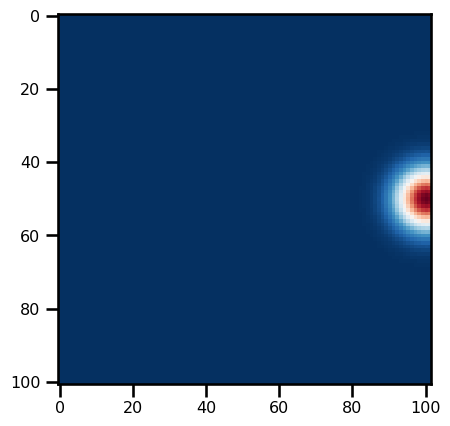

In [4]:
plt.imshow(state_init.h, cmap="RdBu_r")

## Boundary Conditions

## Equation of Motion

In [36]:
class LinearShallowWater2D(DynamicalSystem):
    @staticmethod
    def equation_of_motion(t: float, state: State, args):
        """2D Linear Shallow Water Equations

        Equation:
            ∂h/∂t + H (∂u/∂x + ∂v/∂y) = 0
            ∂u/∂t - fv = - g ∂h/∂x - ku
            ∂v/∂t + fu = - g ∂h/∂y - kv
        """
        # unpack state
        u, v, h = state.u, state.v, state.h

        # unpack params
        depth, coriolis, gravity, domain = (
            args.depth,
            args.coriolis,
            args.gravity,
            args.domain,
        )

        # # Apply Boundary Conditions
        # u = bc_fn(u)
        # v = bc_fn(v)
        u = u.at[-2, :].set(jnp.asarray(0.0))
        v = v.at[:, -2].set(jnp.asarray(0.0))

        ################
        # H COMPONENT
        # ∂h/∂t = - H (∂u/∂x + ∂v/∂y)
        ################
        h_rhs = jnp.zeros_like(h)

        du_dx = fdx.difference(
            u, axis=0, accuracy=1, method="backward", step_size=domain.dx[0]
        )
        dv_dy = fdx.difference(
            v, axis=1, accuracy=1, method="backward", step_size=domain.dx[1]
        )

        h_rhs = h_rhs.at[1:-1, 1:-1].set(
            -depth * (du_dx[1:-1, 1:-1] + dv_dy[1:-1, 1:-1])
        )

        ################
        # U COMPONENT
        # ∂u/∂t = fv - g ∂h/∂x
        ################
        u_rhs = jnp.zeros_like(u)

        v_avg = F_grid.center_average_2D(v, padding="valid")[1:, :-1]
        v_avg *= coriolis

        dh_dx = fdx.difference(
            h, axis=0, accuracy=1, method="forward", step_size=domain.dx[0]
        )
        dh_dx *= -gravity

        u_rhs = u_rhs.at[1:-1, 1:-1].set(v_avg + dh_dx[1:-1, 1:-1])

        ################
        # V COMPONENT
        # ∂v/∂t = - fu - g ∂h/∂y
        ###############

        v_rhs = jnp.zeros_like(v)

        u_avg = F_grid.center_average_2D(u, padding="valid")[:-1, 1:]
        u_avg *= -coriolis

        dh_dy = fdx.difference(
            h, axis=1, accuracy=1, method="forward", step_size=domain.dx[1]
        )
        dh_dy *= -gravity

        v_rhs = v_rhs.at[1:-1, 1:-1].set(u_avg + dh_dy[1:-1, 1:-1])

        # update state
        state = eqx.tree_at(lambda x: x.u, state, u_rhs)
        state = eqx.tree_at(lambda x: x.v, state, v_rhs)
        state = eqx.tree_at(lambda x: x.h, state, h_rhs)
        return state

In [37]:
state_update = LinearShallowWater2D.equation_of_motion(0, state_init, params)

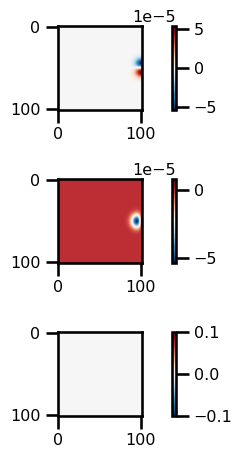

In [38]:
fig, ax = plt.subplots(nrows=3)
pts = ax[0].imshow(state_update.u, cmap="RdBu_r")
plt.colorbar(pts)
pts = ax[1].imshow(state_update.v, cmap="RdBu_r")
plt.colorbar(pts)
pts = ax[2].imshow(state_update.h, cmap="RdBu_r")
plt.colorbar(pts)
plt.tight_layout()

## Time Stepping

In [39]:
# TEMPORAL DISCRETIZATION
# initialize temporal domain

dt = 0.25 * domain.dx[0] / np.sqrt(params.gravity * params.depth)
print(f"Step Size (dt): {dt:.4e}")

tmin = 0.0
tmax = pd.to_timedelta(5, unit="days").total_seconds()
num_save = 60

Step Size (dt): 1.5964e+02


In [40]:
import pandas as pd

In [41]:
t_domain = TimeDomain(tmin=tmin, tmax=tmax, dt=dt)
ts = jnp.linspace(tmin, tmax, num_save)
saveat = dfx.SaveAt(ts=ts)

# DYNAMICAL SYSTEM
dyn_model = LinearShallowWater2D(t_domain=t_domain, saveat=saveat)

### Integration

In [42]:
# Euler, Constant StepSize
solver = dfx.Dopri5()

# Tolerances
stepsize_controller = dfx.ConstantStepSize()
# rtol = 1e-3
# atol = 1e-4
# stepsize_controller = dfx.PIDController(
#     pcoeff=0.3, icoeff=0.4, rtol=rtol, atol=atol, dtmax=dt
# )

# SPATIAL DISCRETIZATION
params_init = Params(depth=100.0, gravity=9.81, coriolis=2e-4, domain=domain)
state_init = State.init_state(params_init, init_h0)


# integration
sol = dfx.diffeqsolve(
    terms=dfx.ODETerm(dyn_model.equation_of_motion),
    solver=solver,
    t0=ts.min(),
    t1=ts.max(),
    dt0=dt,
    y0=state_init,
    saveat=saveat,
    args=params_init,
    stepsize_controller=stepsize_controller,
    max_steps=None,
)

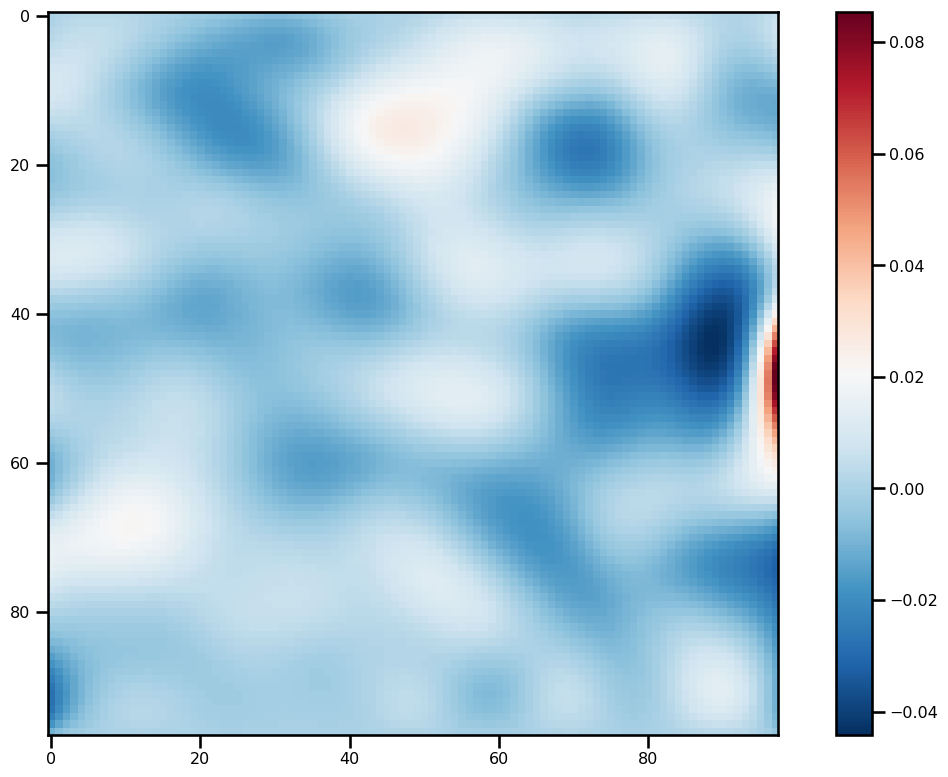

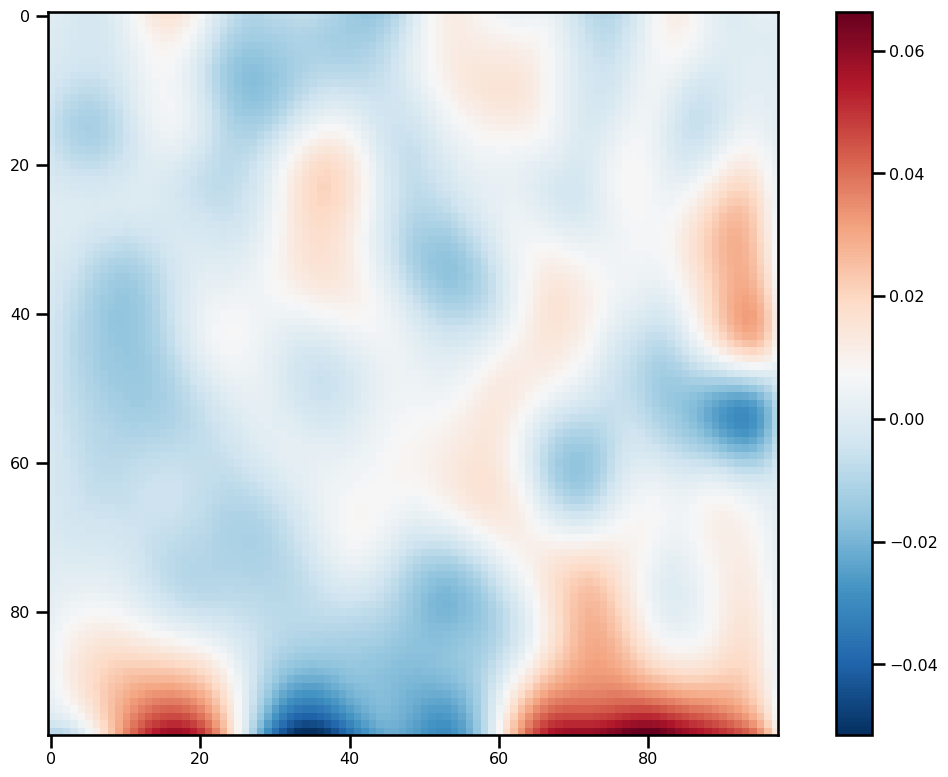

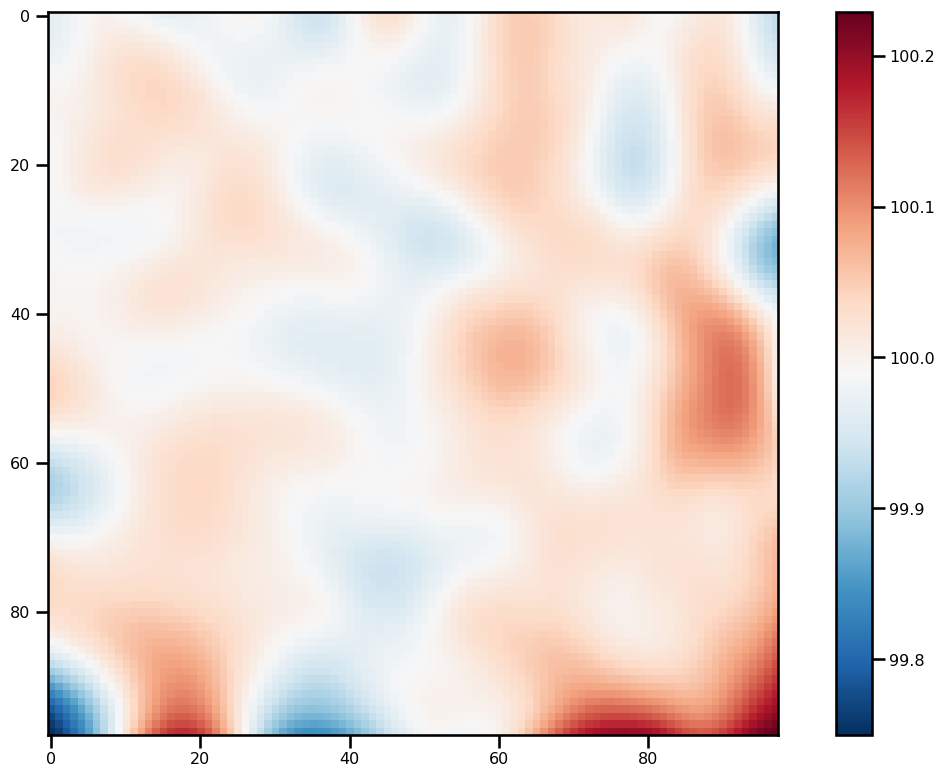

In [43]:
for ivar in sol.ys:
    fig, ax = plt.subplots(figsize=(12, 8))
    pts = ax.imshow(ivar[-1][2:-2, 2:-2], cmap="RdBu_r")
    plt.colorbar(pts)
    plt.tight_layout()

## Analysis

In [44]:
ds_results = xr.Dataset(
    data_vars={
        "u": (("time", "x", "y"), sol.ys.u),
        "v": (("time", "x", "y"), sol.ys.v),
        "h": (("time", "x", "y"), sol.ys.h),
    },
    coords={
        "time": (("time"), sol.ts),
        "x": (("x"), domain.coords[0]),
        "y": (("y"), domain.coords[1]),
    },
)
ds_results

<xarray.Dataset>
Dimensions:  (time: 60, x: 101, y: 102)
Coordinates:
  * time     (time) float64 0.0 7.322e+03 1.464e+04 ... 4.247e+05 4.32e+05
  * x        (x) float64 0.0 2e+04 4e+04 6e+04 ... 1.96e+06 1.98e+06 2e+06
  * y        (y) float64 0.0 2e+04 4e+04 6e+04 ... 1.98e+06 2e+06 2.02e+06
Data variables:
    u        (time, x, y) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    v        (time, x, y) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    h        (time, x, y) float64 100.0 100.0 100.0 100.0 ... 100.0 100.0 100.0

In [45]:
from xmovie import Movie
from pathlib import Path
from matplotlib import ticker


def custom_plot_p_layers(ds, fig, tt, *args, **kwargs):
    sub = ds.isel(time=tt)
    time = sub.v.time.values / 86400

    xlim = kwargs.pop("xlim", None)
    ylim = kwargs.pop("ylim", None)
    vmin = kwargs.pop("vmin", sub.h.isel(x=slice(1, -1), y=slice(1, -1)).min())
    vmax = kwargs.pop("vmax", sub.h.isel(x=slice(1, -1), y=slice(1, -1)).max())
    cmap = kwargs.pop("cmap", "viridis")

    fig.set_size_inches(15, 4.5)

    ax = fig.subplots(
        ncols=3,
    )

    # HEIGHT
    cbar_kwargs = {"label": "Height [m]"}
    pts = sub.h.isel(x=slice(1, -1), y=slice(1, -1)).plot.pcolormesh(
        ax=ax[0],
        cmap="viridis",
        add_colorbar=True,
        vmin=vmin,
        vmax=vmax,
        cbar_kwargs=cbar_kwargs,
        # **kwargs
    )
    loc = ticker.MaxNLocator(6)
    levels = loc.tick_values(vmin, vmax)
    sub.h.isel(x=slice(1, -1), y=slice(1, -1)).plot.contour(
        ax=ax[0],
        levels=levels,
        vmin=vmin,
        vmax=vmax,
        alpha=0.5,
        linewidths=1,
        cmap="black",
        linestyles=np.where(levels >= 0, "-", "--"),
    )

    # ax.set_aspect('equal')
    pts = ax[0].set(xlabel="x [m]", ylabel="y [m]", title=f"Time: {time:.4f} day(s)")

    # U-VELOCITY
    cbar_kwargs = {"label": "U-Velocity [ms$^{-1}$]"}
    vmin = sub.u.isel(x=slice(1, -2), y=slice(1, -1)).min()
    vmax = sub.u.isel(x=slice(1, -2), y=slice(1, -1)).max()
    pts = sub.u.isel(x=slice(1, -2), y=slice(1, -1)).plot.pcolormesh(
        ax=ax[1],
        cmap="coolwarm",
        add_colorbar=True,
        vmin=vmin,
        vmax=vmax,
        cbar_kwargs=cbar_kwargs
        # **kwargs
    )
    loc = ticker.MaxNLocator(6)
    levels = loc.tick_values(vmin, vmax)
    sub.u.isel(x=slice(1, -2), y=slice(1, -1)).plot.contour(
        ax=ax[1],
        levels=levels,
        vmin=vmin,
        vmax=vmax,
        alpha=0.5,
        linewidths=1,
        cmap="black",
        linestyles=np.where(levels >= 0, "-", "--"),
    )

    # ax.set_aspect('equal')
    pts = ax[1].set(xlabel="x [m]", ylabel="y [m]", title=f"Time: {time:.4f} day(s)")

    # V-VELOCITY
    cbar_kwargs = {"label": "V-Velocity [ms$^{-1}$]"}
    vmin = sub.v.isel(x=slice(1, -1), y=slice(1, -2)).min()
    vmax = sub.v.isel(x=slice(1, -1), y=slice(1, -2)).max()
    pts = sub.v.isel(x=slice(1, -1), y=slice(1, -2)).plot.pcolormesh(
        ax=ax[2],
        cmap="coolwarm",
        add_colorbar=True,
        vmin=vmin,
        vmax=vmax,
        cbar_kwargs=cbar_kwargs
        # **kwargs
    )
    loc = ticker.MaxNLocator(6)
    levels = loc.tick_values(vmin, vmax)
    sub.v.isel(x=slice(1, -1), y=slice(1, -2)).plot.contour(
        ax=ax[2],
        levels=levels,
        vmin=vmin,
        vmax=vmax,
        alpha=0.5,
        linewidths=1,
        cmap="black",
        linestyles=np.where(levels >= 0, "-", "--"),
    )

    # ax.set_aspect('equal')

    pts = ax[2].set(xlabel="x [m]", ylabel="y [m]", title=f"Time: {time:.4f} day(s)")

    plt.tight_layout()
    return None, None


from xmovie import Movie
from pathlib import Path
from matplotlib import ticker


def custom_plot_h_ke_layers(ds, fig, tt, *args, **kwargs):
    sub = ds.isel(time=tt)
    time = sub.v.time.values / 86400

    xlim = kwargs.pop("xlim", None)
    ylim = kwargs.pop("ylim", None)
    vmin = kwargs.pop("vmin", sub.h.isel(x=slice(1, -1), y=slice(1, -1)).min())
    vmax = kwargs.pop("vmax", sub.h.isel(x=slice(1, -1), y=slice(1, -1)).max())
    cmap = kwargs.pop("cmap", "viridis")

    fig.set_size_inches(10, 4.5)

    ax = fig.subplots(
        ncols=2,
    )

    # HEIGHT
    cbar_kwargs = {"label": "Height [m]"}
    pts = sub.h.isel(x=slice(1, -1), y=slice(1, -1)).plot.pcolormesh(
        ax=ax[0],
        cmap="viridis",
        add_colorbar=True,
        vmin=vmin,
        vmax=vmax,
        cbar_kwargs=cbar_kwargs,
        # **kwargs
    )
    loc = ticker.MaxNLocator(6)
    levels = loc.tick_values(vmin, vmax)
    sub.h.isel(x=slice(1, -1), y=slice(1, -1)).plot.contour(
        ax=ax[0],
        levels=levels,
        vmin=vmin,
        vmax=vmax,
        alpha=0.5,
        linewidths=1,
        cmap="black",
        linestyles=np.where(levels >= 0, "-", "--"),
    )

    # ax.set_aspect('equal')
    pts = ax[0].set(xlabel="x [m]", ylabel="y [m]", title=f"Time: {time:.4f} day(s)")

    # U-VELOCITY
    sub["ke"] = np.sqrt(0.5 * (sub.u**2 + sub.v**2))
    cbar_kwargs = {"label": "√ Kinetic Energy [ms$^{-1}$]"}
    vmin = sub.ke.isel(x=slice(1, -2), y=slice(1, -2)).min()
    vmax = sub.ke.isel(x=slice(1, -2), y=slice(1, -2)).max()
    pts = sub.ke.isel(x=slice(1, -2), y=slice(1, -2)).plot.pcolormesh(
        ax=ax[1],
        cmap="YlGnBu_r",
        add_colorbar=True,
        vmin=vmin,
        vmax=vmax,
        cbar_kwargs=cbar_kwargs
        # **kwargs
    )
    loc = ticker.MaxNLocator(6)
    levels = loc.tick_values(vmin, vmax)
    sub.ke.isel(x=slice(1, -2), y=slice(1, -2)).plot.contour(
        ax=ax[1],
        levels=levels,
        vmin=vmin,
        vmax=vmax,
        alpha=0.5,
        linewidths=1,
        cmap="black",
        linestyles=np.where(levels >= 0, "-", "--"),
    )

    # ax.set_aspect('equal')
    pts = ax[1].set(xlabel="x [m]", ylabel="y [m]", title=f"Time: {time:.4f} day(s)")

    plt.tight_layout()
    return None, None


from pathlib import Path


def create_movie(
    var,
    name,
    plotfunc=custom_plot_p_layers,
    framedim: str = "steps",
    file_path=None,
    **kwargs,
):
    if file_path is not None:
        file_name = Path(file_path).joinpath(f"movie_{name}.gif")
    else:
        file_name = Path(f"./movie_{name}.gif")

    mov = Movie(
        var, plotfunc=plotfunc, framedim=framedim, **kwargs, dpi=200, input_check=False
    )
    mov.save(
        file_name,
        remove_movie=False,
        progress=True,
        framerate=3,
        gif_framerate=3,
        overwrite_existing=True,
        gif_resolution_factor=0.5,
        parallel=False,
    )

    return None

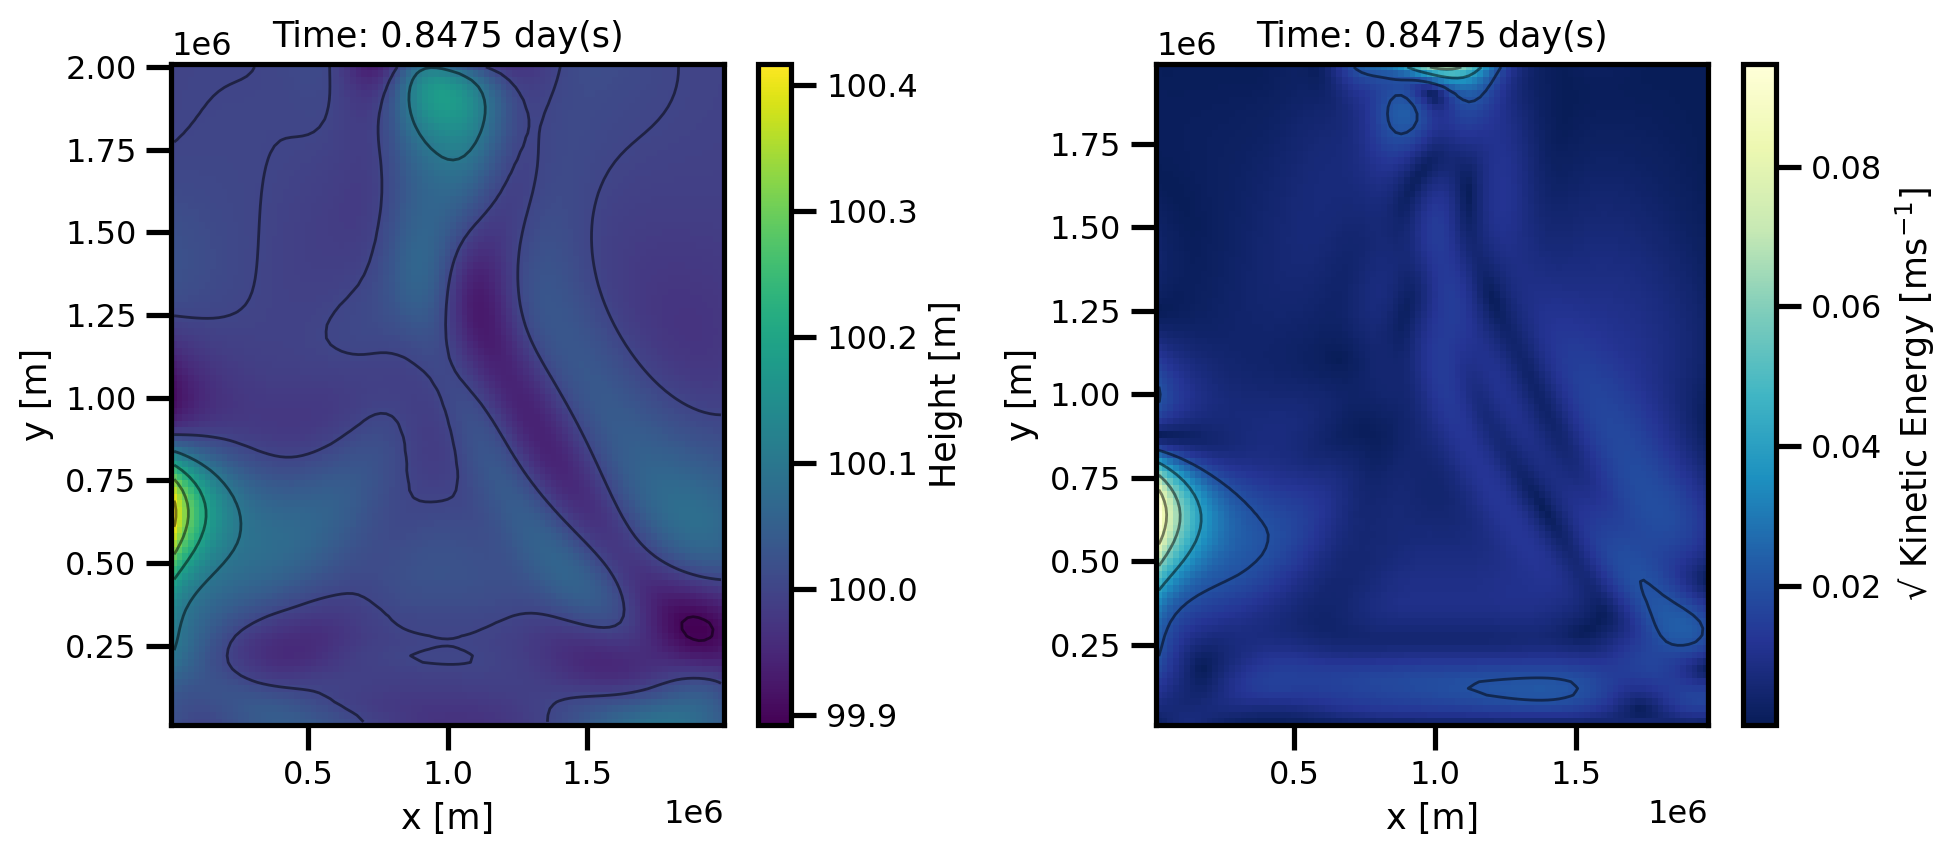

In [47]:
%matplotlib inline
mov = Movie(
    ds_results.transpose("time", "y", "x"),
    plotfunc=custom_plot_h_ke_layers,
    framedim="time",
    input_check=False,
)
mov.preview(10)

In [46]:
create_movie(
    ds_results.transpose(
        "time", "y", "x"
    ),  # .sel(time=slice("2017-02-01", "2017-03-01")),
    name="swe_linear",
    plotfunc=custom_plot_h_ke_layers,
    file_path="./",
    framedim="time",
    cmap="viridis",
    robust=True,
)

  0%|          | 0/60 [00:00<?, ?it/s]

Movie created at movie_swe_linear.mp4
GIF created at movie_swe_linear.gif
